<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
# Ejercicio 4
# Alumno: Jorge Heyul Chavez Arias
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.layers import Bidirectional

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3820673029293027747
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10933711668
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13847193629492206700
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [3]:
#tf.test.is_gpu_available()

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [3]:
# Descargar la carpeta de dataset
import os
import platform
import urllib.request
import bs4 as bs
import re # Regular Expressions (regex)

In [4]:
raw_html = urllib.request.urlopen('https://www.textos.info/varios/biblia/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text

article_text = article_text.lower()

# substituir con regex con espacio vacío:
text = re.sub(r'\[[0-9]*\]', ' ', article_text) # substituir los números entre corchetes
# (notar que los corchetes son interpretados literalmente por los backlsash)
text = re.sub(r'\s+', ' ', text) # substituir más de un caracter de espacio, salto de línea o tabulación
  


In [5]:
def str2frame(estr, sep = '', lineterm = '.', set_header = False):
    dat = [x for x in estr.split(lineterm)][1:-1]
    df = pd.DataFrame(dat)
    if set_header:
        df = df.T.set_index(0, drop = True).T 
    return df

In [6]:
df = str2frame(text)
df

,0
0,la tierra era caos y confusión y oscuridad po...
1,"dijo dios: «haya luz», y hubo luz"
2,"vio dios que la luz estaba bien, y apartó dio..."
3,y atardeció y amaneció: día primero
4,dijo dios: «haya un firmamento por en medio d...
...,...
33978,"biblioteca digital abierta, legal y gratuita p..."
33979,"hotel maison carrée c/ des ramal, 48 07730 ala..."
33980,info es un proyecto gratuito de promoción de l...
33981,ayúdanos a que nuestros libros lleguen a más g...


In [7]:
df = df[0:10000]
df

,0
0,la tierra era caos y confusión y oscuridad po...
1,"dijo dios: «haya luz», y hubo luz"
2,"vio dios que la luz estaba bien, y apartó dio..."
3,y atardeció y amaneció: día primero
4,dijo dios: «haya un firmamento por en medio d...
...,...
9995,su padre les dijo: «¿por qué camino se ha ido...
9996,dijo a sus hijos: «aparejadme el asno
9997,» y aparejaron el asno y se montó sobre él
9998,fue en seguimiento del hombre de dios y le en...


In [8]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 10000


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [9]:
from keras_preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras_preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
#from keras.utils import pad_sequences # se utilizará para padding
from keras_preprocessing.sequence import pad_sequences

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [10]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

' la tierra era caos y confusión y oscuridad por encima del abismo, y un viento de dios aleteaba por encima de las aguas'

In [11]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['la',
 'tierra',
 'era',
 'caos',
 'y',
 'confusión',
 'y',
 'oscuridad',
 'por',
 'encima',
 'del',
 'abismo',
 'y',
 'un',
 'viento',
 'de',
 'dios',
 'aleteaba',
 'por',
 'encima',
 'de',
 'las',
 'aguas']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [12]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [13]:
# Demos un vistazo
sentence_tokens[:2]

[['la',
  'tierra',
  'era',
  'caos',
  'y',
  'confusión',
  'y',
  'oscuridad',
  'por',
  'encima',
  'del',
  'abismo',
  'y',
  'un',
  'viento',
  'de',
  'dios',
  'aleteaba',
  'por',
  'encima',
  'de',
  'las',
  'aguas'],
 ['dijo', 'dios', '«haya', 'luz»', 'y', 'hubo', 'luz']]

In [14]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [15]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['la', 'tierra', 'era', 'caos'],
 ['tierra', 'era', 'caos', 'y'],
 ['era', 'caos', 'y', 'confusión'],
 ['caos', 'y', 'confusión', 'y'],
 ['y', 'confusión', 'y', 'oscuridad'],
 ['confusión', 'y', 'oscuridad', 'por'],
 ['y', 'oscuridad', 'por', 'encima'],
 ['oscuridad', 'por', 'encima', 'del'],
 ['por', 'encima', 'del', 'abismo'],
 ['encima', 'del', 'abismo', 'y'],
 ['del', 'abismo', 'y', 'un'],
 ['abismo', 'y', 'un', 'viento'],
 ['y', 'un', 'viento', 'de'],
 ['un', 'viento', 'de', 'dios'],
 ['viento', 'de', 'dios', 'aleteaba'],
 ['de', 'dios', 'aleteaba', 'por'],
 ['dios', 'aleteaba', 'por', 'encima'],
 ['aleteaba', 'por', 'encima', 'de'],
 ['por', 'encima', 'de', 'las']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [16]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [17]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[16, 15, 14, 5],
 [15, 14, 5, 1],
 [14, 5, 1, 6],
 [5, 1, 6, 1],
 [1, 6, 1, 7],
 [6, 1, 7, 2],
 [1, 7, 2, 3],
 [7, 2, 3, 8],
 [2, 3, 8, 9],
 [3, 8, 9, 1],
 [8, 9, 1, 10],
 [9, 1, 10, 11],
 [1, 10, 11, 4],
 [10, 11, 4, 12],
 [11, 4, 12, 13],
 [4, 12, 13, 2],
 [12, 13, 2, 3],
 [13, 2, 3, 4],
 [2, 3, 4, 17]]

In [18]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

19


In [19]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

17


In [20]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'y': 1, 'por': 2, 'encima': 3, 'de': 4, 'caos': 5, 'confusión': 6, 'oscuridad': 7, 'del': 8, 'abismo': 9, 'un': 10, 'viento': 11, 'dios': 12, 'aleteaba': 13, 'era': 14, 'tierra': 15, 'la': 16, 'las': 17}


In [21]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'tierra': 2, 'caos': 4, 'era': 3, 'la': 1, 'y': 10, 'confusión': 4, 'oscuridad': 4, 'por': 8, 'encima': 7, 'del': 4, 'abismo': 4, 'un': 4, 'viento': 4, 'de': 6, 'dios': 4, 'aleteaba': 4, 'las': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [22]:
# Vistazo a las primeras filas
df.loc[:15,0]

0      la tierra era caos y confusión y oscuridad po...
1                     dijo dios: «haya luz», y hubo luz
2      vio dios que la luz estaba bien, y apartó dio...
3                   y atardeció y amaneció: día primero
4      dijo dios: «haya un firmamento por en medio d...
5     » e hizo dios el firmamento; y apartó las agua...
6                                             y así fue
7                     y llamó dios al firmamento cielos
8                   y atardeció y amaneció: día segundo
9      dijo dios: «acumúlense las aguas de por debaj...
10     y llamó dios a lo seco tierra, y al conjunto ...
11     dijo dios: «produzca la tierra vegetación: hi...
12                                          » y así fue
13     la tierra produjo vegetación: hierbas que dan...
14                  y atardeció y amaneció: día tercero
15     dijo dios: «haya luceros en el firmamento cel...
Name: 0, dtype: object

In [25]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus[0:200]

' la tierra era caos y confusión y oscuridad por encima del abismo, y un viento de dios aleteaba por encima de las aguas  dijo dios: «haya luz», y hubo luz  vio dios que la luz estaba bien, y apartó di'

In [27]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:15]

['la',
 'tierra',
 'era',
 'caos',
 'y',
 'confusión',
 'y',
 'oscuridad',
 'por',
 'encima',
 'del',
 'abismo',
 'y',
 'un',
 'viento']

In [28]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 220156


In [29]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [30]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:15]

[['la', 'tierra', 'era', 'caos'],
 ['tierra', 'era', 'caos', 'y'],
 ['era', 'caos', 'y', 'confusión'],
 ['caos', 'y', 'confusión', 'y'],
 ['y', 'confusión', 'y', 'oscuridad'],
 ['confusión', 'y', 'oscuridad', 'por'],
 ['y', 'oscuridad', 'por', 'encima'],
 ['oscuridad', 'por', 'encima', 'del'],
 ['por', 'encima', 'del', 'abismo'],
 ['encima', 'del', 'abismo', 'y'],
 ['del', 'abismo', 'y', 'un'],
 ['abismo', 'y', 'un', 'viento'],
 ['y', 'un', 'viento', 'de'],
 ['un', 'viento', 'de', 'dios'],
 ['viento', 'de', 'dios', 'aleteaba']]

In [31]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:15]

[[4, 39, 98, 7528],
 [39, 98, 7528, 2],
 [98, 7528, 2, 5259],
 [7528, 2, 5259, 2],
 [2, 5259, 2, 2935],
 [5259, 2, 2935, 14],
 [2, 2935, 14, 289],
 [2935, 14, 289, 13],
 [14, 289, 13, 2569],
 [289, 13, 2569, 2],
 [13, 2569, 2, 22],
 [2569, 2, 22, 2936],
 [2, 22, 2936, 1],
 [22, 2936, 1, 26],
 [2936, 1, 26, 7529]]

In [32]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 220152


### 3 - Input y target

In [33]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(220152, 3)
(220152,)


In [57]:
# Palabras del vocabulario
print(tok.index_word[1])
print(tok.index_word[2])
print(tok.index_word[3])
print(tok.index_word[4])

de
y
a
la


In [58]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

14433

In [59]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size+1)

In [60]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [61]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(220152, 14433)

### 4 - Entrenar el modelo

In [62]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [63]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

14433

In [64]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.3))
model.add(LSTM(32)) # La última capa LSTM no lleva return_sequences
model.add(Dense(16, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3, 5)              72170     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 3, 64)             9728      
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 14433)             245361    
Total params: 340,203
Trainable params: 340,203
Non-trainable params: 0
________________________________________________

In [65]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

c:\Users\heyul\anaconda3\envs\TF21\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 176121 samples, validate on 44031 samples
Epoch 1/50
176121/176121 [==============================] - 91s 515us/step - loss: 6.5396 - accuracy: 0.0660 - val_loss: 6.7448 - val_accuracy: 0.0765
Epoch 2/50
176121/176121 [==============================] - 61s 344us/step - loss: 5.9442 - accuracy: 0.0963 - val_loss: 6.7717 - val_accuracy: 0.0929
Epoch 3/50
176121/176121 [==============================] - 60s 340us/step - loss: 5.6713 - accuracy: 0.1157 - val_loss: 6.7873 - val_accuracy: 0.1046
Epoch 4/50
176121/176121 [==============================] - 61s 348us/step - loss: 5.4682 - accuracy: 0.1306 - val_loss: 6.7820 - val_accuracy: 0.1129
Epoch 5/50
176121/176121 [==============================] - 61s 346us/step - loss: 5.3136 - accuracy: 0.1411 - val_loss: 6.8711 - val_accuracy: 0.1179
Epoch 6/50
176121/176121 [==============================] - 61s 349us/step - loss: 5.2025 - accuracy: 0.1484 - val_loss: 6.8962 - val_accuracy: 0.1226
Epoch 7/50
176121/176121 [=================

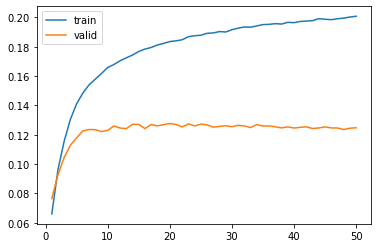

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [42]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [43]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
#!{sys.executable} -m pip install gradio --quiet

### 6 - Generación de secuencias nuevas

In [45]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [111]:
input_text='tu pueblo es'

generate_seq(model, tok, input_text, max_length=3, n_words=3)

'tu pueblo es el israelitas de'

### 7 - Conclusiones
- Se agregaron mas neuronas y capas al modelo, sin embargo, esto aumentaba el overfitting llegando a más de 0.9 de accuracy para los datos de entrenamiento y 0.09 para los de validación, esto quiere decir que la red está memorizando los datos.
- Se aumentó la cantidad de épocas, y esto aumento el accuracy, sin embargo, tambien aumentaba la diferencia del accuracy enrtre los datos de entrenamiento y validación.
- Al agregar la BRNN mejoró la predicción y el Dropout a 0.3 tambien se notó una mejora.
- Finalmente se cambio el corpus, y se cambió por el de la biblia, y se limitó a 10000 documentos y como se puede ver en la grafica se eliminó significativamente el overfitting, logrando un acc_train de 0.2 y yb acc-valid de 0.12, mucho mejor que los resultados anteriores. Sin embargo, se concluye que aún se necesita un corpus mayor, pero se logra unos resultados interesantes como se muestra a continuacion:

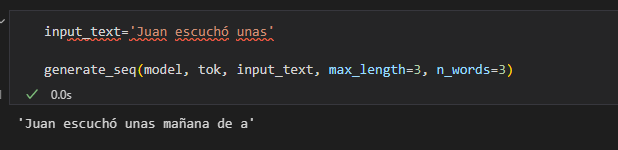

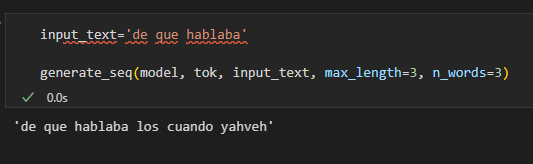

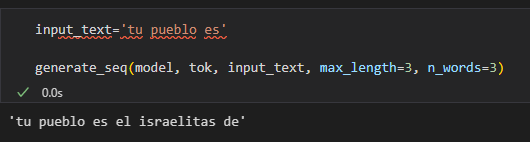